# Cosine plots of BGCs

This Notebook will prepare figures describing the set of BGCs obtained from endolichenic fungi recovered from New Zealand lichens.

A cosine analysis will also be prepared from data generated by BiG-SLiCE. This analysis returns distances that are less weighted by the number of features, so BGCs with fewer features like RiPPs and terpenes. More information regarding this can be found in the Supplementary Information of the wonderful paper by [Paoli et al., 2022](https://www.nature.com/articles/s41586-022-04862-3#MOESM1). The code in this Notebook was written, with minor alterations, by Dr Peng Hou.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict
import numpy as np
from scipy import stats

## Plotting cosine analysis of BiG-SLiCE output data

In [5]:
# import all BGC information
bigslice0 = pd.read_csv('ELF_ref.csv')
bigslice0['genome'] = bigslice0['bgc'].str.split('.').str[0]
fungal_class = pd.read_excel(open('taxon.xlsx', 'rb'), sheet_name='lichen')
result = fungal_class[['lichen','fungal_class']].rename(columns={'lichen':'genome','fungal_class':'class'})
bigslice=pd.merge(result,bigslice0[['bgc','bigslice_subclass','bigslice_class','genome']],left_on='genome',right_on='genome')
bigslice_count = len(bigslice0[bigslice0["source"] == "BiG-SLiCE"])
mibig_count = len(bigslice0[bigslice0["source"] == "MiBIG"])
print("BGC information:")
display(bigslice.head())

# import cosine distances
df3 = pd.read_csv('cosine_distances.csv').replace({'.gbk':''}, regex=True).rename(columns={'0':'bgc','0.1':'min.cosine'})[['bgc','min.cosine']]
print("\nCosine distances:")
display(df3.head())

# import GCFs
df1=pd.read_csv('gcfs.csv')[['BGC','GCF','GCC']].replace({'.gbk':''}, regex=True)
fungal_GC = df1[df1["BGC"].str.contains('lichen', case=False)]
print("\nGCFs:")
display(df1.head())

# merge BGC dataset and cosine distances
minValues1=pd.merge(df3,bigslice[['genome','bgc','bigslice_class']],left_on='bgc',right_on='bgc').rename(columns={'bigslice_class': 'BiG-SLiCE class'})
minValues1.to_csv("minvalues1.csv")
print("\nmerged:")
display(minValues1.head())

# prepare dict of GCFs
GCF_dict0 = pd.merge(minValues1,df1,left_on='bgc', right_on='BGC').T.to_dict()
GCF_dict = defaultdict(list)

for k,v in GCF_dict0.items():
    GCF_dict[v['GCF']].append(v['min.cosine'])

GCF_dict1 = {}
for k,v in GCF_dict.items():
    GCF_dict1[k] = min(v)
    GCF_dict[k] = sum(v)/len(v)
    
GCF_avg = pd.DataFrame.from_dict(GCF_dict,orient = 'index')
GCF_min = pd.DataFrame.from_dict(GCF_dict1,orient = 'index')
all_GCF = len(df1["GCF"].unique())
all_GCC = len(df1["GCC"].unique())
fungal_GCF = len(fungal_GC["GCF"].unique())
fungal_GCC = len(fungal_GC["GCC"].unique())
avg_novel_fungal_GCF = len(GCF_avg[GCF_avg[0]>0.2])
avg_novel_fungal_GCC = len(GCF_avg[GCF_avg[0]>0.4])
min_novel_fungal_GCF = len(GCF_avg[GCF_avg[0]>0.2])
min_novel_fungal_GCC = len(GCF_avg[GCF_avg[0]>0.4])

# find highest diversity strains
gc_summary = pd.DataFrame()
fungal_GC["assembly"] = fungal_GC["BGC"].str.split(".").str[0]
gc_summary["GCF_unique"] = fungal_GC.groupby('assembly')['GCF'].nunique().sort_values(ascending=False)
gc_summary["GCC_unique"] = fungal_GC.groupby('assembly')['GCC'].nunique().sort_values(ascending=False)
gc_summary.to_csv("GC_summary.csv")
print("\nHighest GCF/GCC strains:")
display(gc_summary.head(n=10))

# subset BGCs with identified taxonomy
minValues2 = pd.merge(minValues1,result,left_on='genome', right_on='genome').reset_index()
minValues2 = minValues2[minValues2['class']!='unidentified']
minValues2.loc[minValues2['min.cosine'] <= 0.2, 'Novelty'] = 'min(d)<0.2'
minValues2.loc[minValues2['min.cosine'] > 0.2, 'Novelty'] = 'min(d)>0.2'
minValues1.loc[minValues1['min.cosine'] <= 0.2, 'Novelty'] = 'min(d)<0.2'
minValues1.loc[minValues1['min.cosine'] > 0.2, 'Novelty'] = 'min(d)>0.2'
minValues2 = minValues2.rename(columns={'bgc': 'BGC'})

gcf_ = df1[df1.apply(lambda row: row.astype(str).str.contains('lichen').any(), axis=1)]
merged_all_bgc = pd.merge(minValues2, gcf_, on="BGC", how="outer")
novel_GCFs = merged_all_bgc.groupby('GCF').filter(lambda x: (x['min.cosine'] >0.2).all())
novel_GCFs.to_csv("only_novel_GCFs.csv")
novel_GCF = novel_GCFs["GCF"].nunique()
novel_GCF_GCCs = novel_GCFs["GCC"].nunique()
display(novel_GCFs)
display(minValues2)

fungal = minValues2.groupby(['class','Novelty']).size().reset_index()
fungal1 = fungal.pivot(index='class', columns='Novelty', values=0).fillna(0)
fungal1 = fungal1.reindex(columns=['min(d)<0.2','min(d)>0.2'])
fungal2 = minValues1.groupby(['BiG-SLiCE class','Novelty']).size().reset_index()
fungal2
fungal2 = fungal2.pivot(index='BiG-SLiCE class', columns='Novelty', values=0).fillna(0)
fungal2 = fungal2.reindex(columns=['min(d)<0.2','min(d)>0.2'])
fungal2['sum'] = fungal2.sum(axis=1)
fungal2 = fungal2.reset_index()

# calculate diversity of BGCs for each fungal Class
class_order = ["Agaricomycetes", "Dothidiomycetes", "Eurotiomycetes", \
    "Leotiomycetes", "Mucoromycetes", "Pezizomycetes", "Sordariomycetes", \
        "Tremellomycetes", "Umbelopsidomycetes"]

diversity1 = bigslice.groupby(['genome','bigslice_subclass']).size().reset_index()
diversity2 = diversity1.pivot(index='genome', columns='bigslice_subclass', values=0).fillna(0)
diversity2[diversity2 != 0] = 1
diversity3 = diversity2.sum(axis=1).reset_index()
diversity3
diversity4_dict = pd.merge(diversity3,result,left_on='genome', right_on='genome').reset_index().drop_duplicates().T.to_dict()
diversity4_dict
from collections import defaultdict
diversity_dict = defaultdict(list)
for k,v in diversity4_dict.items():
    diversity_dict[v['class']].append(v[0])
from scipy.stats import entropy
for k,v in diversity_dict.items():
    diversity_dict[k] = entropy(v)
diversity_dict
diversity = pd.DataFrame.from_dict(diversity_dict, orient ='index').reset_index().fillna('unidentified')
diversity = diversity[diversity['index']!='unidentified'].set_index('index')
diversity = diversity.sort_index(axis=0, level=class_order)
diversity

# subset BGCs with cosine distance >0.2
minValues3 = minValues1[minValues1["min.cosine"] > 0.2]
all_GCF_counts = minValues1['BiG-SLiCE class'].value_counts()
fungal_GCF_counts = minValues3['BiG-SLiCE class'].value_counts()

# print data
num_BGC = len(bigslice0)
num_fungal_BGC = len(minValues1)
novel_fungal_BGC = len(minValues1[minValues1['min.cosine']>0.2])

print("\n---BGCs---")
print(f"All BGCs:{num_BGC:13}\nBiG-SLiCE:{bigslice_count:12}\nMIBiG:{mibig_count:16}\nFungal BGCs:{num_fungal_BGC:10}")
print(f"\nFungal BGCs >0.2:{novel_fungal_BGC:5}    {round((novel_fungal_BGC/num_fungal_BGC)*100,2)}%")

print("\n---Fungal cosine distances---")
print(f"All GCFs:{all_GCF:13}   Fungal GCFs:{fungal_GCF:9}    {round((fungal_GCF/all_GCF)*100,2):10}%")
print(f"ALL GCCs:{all_GCC:13}   Fungal GCCs:{fungal_GCC:9}    {round((fungal_GCC/all_GCC)*100,2):10}%")
print("Minimum cosine distances:")
print(f"Fungal GCFs:{fungal_GCF:>10}    GCFs >0.2:{min_novel_fungal_GCF:10}    {round((min_novel_fungal_GCF/fungal_GCF)*100,2):10}%")
print(f"Fungal GCCs:{fungal_GCC:10}    GCCs >0.4:{min_novel_fungal_GCC:10}    {round((min_novel_fungal_GCC/fungal_GCC)*100,2):10}%")
print("Average minimum cosine distances:")
print(f"Fungal GCFs:{fungal_GCF:10}    GCFs >0.2:{avg_novel_fungal_GCF:10}    {round((avg_novel_fungal_GCF/fungal_GCF)*100,2):10}%")
print(f"Fungal GCCs:{fungal_GCC:10}    GCCs >0.4:{avg_novel_fungal_GCC:10}    {round((avg_novel_fungal_GCC/fungal_GCC)*100,2):10}%")
print(f"GCFs with only novel BGCs: {novel_GCF:10}\nGCC count for above: {novel_GCF_GCCs:10}")

print("\nBiG-SLiCE Classes")
print(f"Polyketide:{all_GCF_counts[0]:11}    {fungal_GCF_counts[0]:20}    {round((fungal_GCF_counts[0]/all_GCF_counts[0])*100,2):10}%")
print(f"NRP:{all_GCF_counts[1]:18}    {fungal_GCF_counts[1]:20}    {round((fungal_GCF_counts[1]/all_GCF_counts[1])*100,2):10}%")
print(f"Terpene:{all_GCF_counts[2]:14}    {fungal_GCF_counts[2]:20}    {round((fungal_GCF_counts[2]/all_GCF_counts[2])*100,2):10}%")
print(f"Other:{all_GCF_counts[3]:16}    {fungal_GCF_counts[3]:20}    {round((fungal_GCF_counts[3]/all_GCF_counts[3])*100,2):10}%")
print(f"RiPP:{all_GCF_counts[4]:17}    {fungal_GCF_counts[4]:20}    {round((fungal_GCF_counts[4]/all_GCF_counts[4])*100,2):10}%")

BGC information:


,genome,class,bgc,bigslice_subclass,bigslice_class
0,lichen_1,Sordariomycetes,lichen_1.c00123_NODE_12...region001,class-NRP:NRPS-like,class-NRP
1,lichen_1,Sordariomycetes,lichen_1.c00017_NODE_17...region001,class-Polyketide:T1PKS,class-Polyketide
2,lichen_1,Sordariomycetes,lichen_1.c00074_NODE_74...region001,class-NRP:generic,class-NRP
3,lichen_1,Sordariomycetes,lichen_1.c00020_NODE_20...region001,class-Polyketide:T1PKS,class-Polyketide
4,lichen_1,Sordariomycetes,lichen_1.c00013_NODE_13...region001,class-Polyketide:T1PKS,class-Polyketide



Cosine distances:


,bgc,min.cosine
0,lichen_1.c00009_NODE_9_...region001,0.019268
1,lichen_1.c00013_NODE_13...region001,0.038044
2,lichen_1.c00014_NODE_14...region001,0.011383
3,lichen_1.c00017_NODE_17...region001,0.056056
4,lichen_1.c00020_NODE_20...region001,0.173857



GCFs:


,BGC,GCF,GCC
0,AE016814.2.region001,GCF_270,GCC_2
1,AE016817.6.region001,GCF_417,GCC_46
2,AE016819.5.region001,GCF_1070,GCC_75
3,AE016820.4.region001,GCF_288,GCC_30
4,AE017343.1.region001,GCF_1063,GCC_75



merged:


,bgc,min.cosine,genome,BiG-SLiCE class
0,lichen_1.c00009_NODE_9_...region001,0.019268,lichen_1,class-Polyketide
1,lichen_1.c00013_NODE_13...region001,0.038044,lichen_1,class-Polyketide
2,lichen_1.c00014_NODE_14...region001,0.011383,lichen_1,class-Polyketide
3,lichen_1.c00017_NODE_17...region001,0.056056,lichen_1,class-Polyketide
4,lichen_1.c00020_NODE_20...region001,0.173857,lichen_1,class-Polyketide



Highest GCF/GCC strains:


C:\Users\styleske\AppData\Local\Temp\ipykernel_2380\3888065.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fungal_GC["assembly"] = fungal_GC["BGC"].str.split(".").str[0]


,GCF_unique,GCC_unique
assembly,,
lichen_48,50,11
lichen_93,49,10
lichen_41,47,10
lichen_94,43,10
lichen_293,42,10
lichen_127,41,12
lichen_170,40,11
lichen_31,40,7
lichen_78,39,10


,index,BGC,min.cosine,genome,BiG-SLiCE class,class,Novelty,GCF,GCC
18,18.0,lichen_10.scaffold_152.region001,0.242430,lichen_10,class-Terpene,Eurotiomycetes,min(d)>0.2,GCF_2574,GCC_36
39,39.0,lichen_10.scaffold_333.region001,0.327693,lichen_10,class-NRP,Eurotiomycetes,min(d)>0.2,GCF_4440,GCC_46
52,52.0,lichen_10.scaffold_58.region001,0.200695,lichen_10,class-NRP,Eurotiomycetes,min(d)>0.2,GCF_3016,GCC_46
61,61.0,lichen_10.scaffold_820.region001,0.223643,lichen_10,class-NRP,Eurotiomycetes,min(d)>0.2,GCF_4454,GCC_4
62,62.0,lichen_10.scaffold_9.region001,0.243637,lichen_10,class-NRP,Eurotiomycetes,min(d)>0.2,GCF_1339,GCC_46
...,...,...,...,...,...,...,...,...,...
4612,4987.0,lichen_71.scaffold_18.region001,0.206825,lichen_71,class-NRP,Sordariomycetes,min(d)>0.2,GCF_1901,GCC_4
4670,5045.0,lichen_78.scaffold_1002.region001,0.328527,lichen_78,class-NRP,Sordariomycetes,min(d)>0.2,GCF_1402,GCC_28
4708,5083.0,lichen_78.scaffold_376.region001,0.218339,lichen_78,class-NRP,Sordariomycetes,min(d)>0.2,GCF_3494,GCC_4
4902,5277.0,lichen_89.scaffold_181.region001,0.222571,lichen_89,class-NRP,Sordariomycetes,min(d)>0.2,GCF_2283,GCC_46


,index,BGC,min.cosine,genome,BiG-SLiCE class,class,Novelty
0,0,lichen_1.c00009_NODE_9_...region001,0.019268,lichen_1,class-Polyketide,Sordariomycetes,min(d)<0.2
1,1,lichen_1.c00013_NODE_13...region001,0.038044,lichen_1,class-Polyketide,Sordariomycetes,min(d)<0.2
2,2,lichen_1.c00014_NODE_14...region001,0.011383,lichen_1,class-Polyketide,Sordariomycetes,min(d)<0.2
3,3,lichen_1.c00017_NODE_17...region001,0.056056,lichen_1,class-Polyketide,Sordariomycetes,min(d)<0.2
4,4,lichen_1.c00020_NODE_20...region001,0.173857,lichen_1,class-Polyketide,Sordariomycetes,min(d)<0.2
...,...,...,...,...,...,...,...
5539,5539,lichen_96.scaffold_694.region001,0.012044,lichen_96,class-NRP,Pezizomycetes,min(d)<0.2
5540,5540,lichen_98.c00005_NODE_5_...region001,0.024189,lichen_98,class-Polyketide,Sordariomycetes,min(d)<0.2
5541,5541,lichen_98.c00011_NODE_11...region001,0.061964,lichen_98,class-Polyketide,Sordariomycetes,min(d)<0.2
5542,5542,lichen_98.c00025_NODE_25...region001,0.032407,lichen_98,class-Polyketide,Sordariomycetes,min(d)<0.2



---BGCs---
All BGCs:        15150
BiG-SLiCE:        7696
MIBiG:            1910
Fungal BGCs:      5544

Fungal BGCs >0.2:  175    3.16%

---Fungal cosine distances---
All GCFs:         4041   Fungal GCFs:      861         21.31%
ALL GCCs:          123   Fungal GCCs:       28         22.76%
Minimum cosine distances:
Fungal GCFs:       861    GCFs >0.2:       143         16.61%
Fungal GCCs:        28    GCCs >0.4:         4         14.29%
Average minimum cosine distances:
Fungal GCFs:       861    GCFs >0.2:       143         16.61%
Fungal GCCs:        28    GCCs >0.4:         4         14.29%
GCFs with only novel BGCs:        121
GCC count for above:         14

BiG-SLiCE Classes
Polyketide:       2622                     111          4.23%
NRP:              2306                      31          1.34%
Terpene:           474                      16          3.38%
Other:             127                      15         11.81%
RiPP:               15                       2         13.33%


### Plots

Comparison of gene cluster classes (GCCs) by fungal Class and BGC product. 

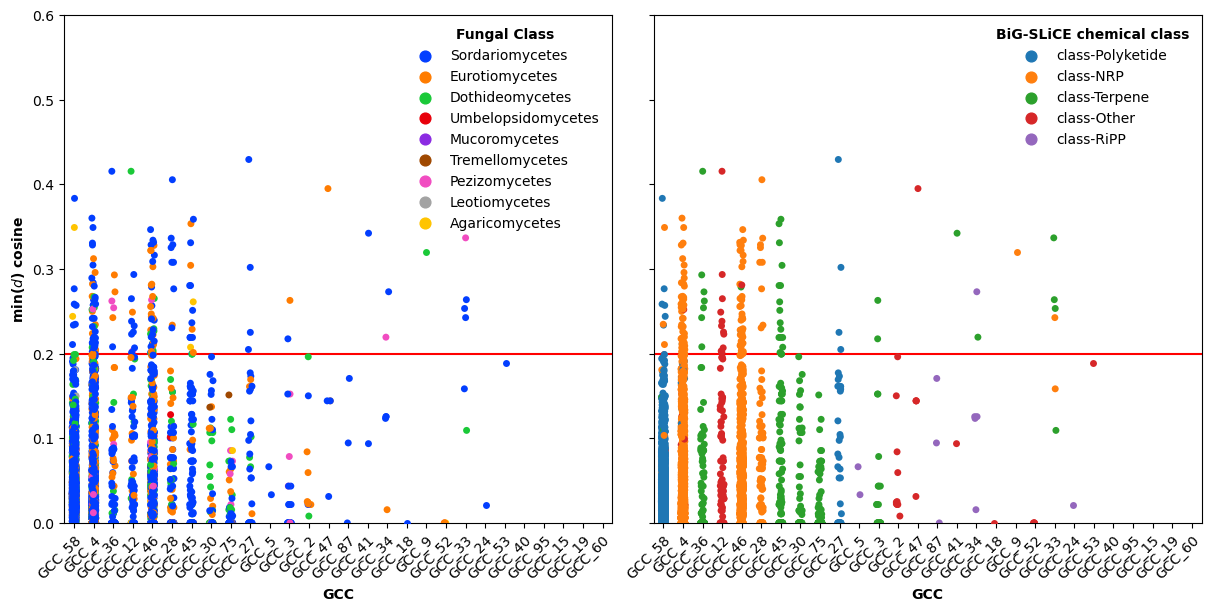

In [6]:
#merged_all_bgc_novel = merged_all_bgc[merged_all_bgc["min.cosine"] > 0.2]
fig, axd = plt.subplots(ncols=2, figsize=(12, 6), layout="constrained", sharey=True)
sns.stripplot(y=merged_all_bgc["min.cosine"], x=merged_all_bgc["GCC"], hue=merged_all_bgc["class"], ax=axd[0], palette="bright")
sns.stripplot(y=merged_all_bgc["min.cosine"], x=merged_all_bgc["GCC"], hue=merged_all_bgc["BiG-SLiCE class"], ax=axd[1])
xlabels = axd[0].get_xticklabels()
axd[0].set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
axd[1].set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
axd[0].set_ylim([0, 0.6])
axd[0].set_ylabel("min($\it{d}$) cosine", fontproperties={'weight':"bold"})
axd[0].set_xlabel("GCC", fontproperties={'weight':"bold"})
axd[0].legend(frameon=False, loc='best', title="Fungal Class", title_fontproperties={'weight':"bold"}, markerscale=1)
axd[1].set_ylabel("")
axd[1].set_xlabel("GCC", fontproperties={'weight':"bold"})
axd[1].legend(frameon=False, loc='best', title="BiG-SLiCE chemical class", title_fontproperties={'weight':"bold"}, markerscale=1)
axd[0].axhline(0.2, color='red')
axd[1].axhline(0.2, color='red')
plt.savefig("GCC_cosine_by_classes.svg", format="svg")
plt.show()

Plot of BGC min cosine scores (d(BiGFAM)) by each BGC type.

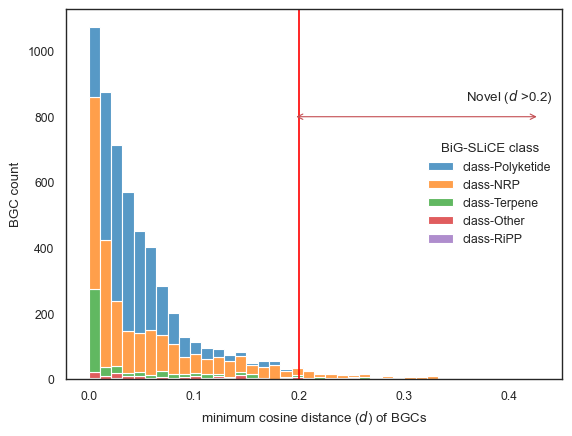

In [34]:
ax = sns.histplot(data=minValues1,x=minValues1['min.cosine'], multiple='stack', hue='BiG-SLiCE class', palette="tab10", bins=40)
plt.axvline(0.2, color='red')
plt.annotate("",
            xy=(0.195, 800), xycoords='data',
            xytext=(max(minValues1['min.cosine']), 800), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
            connectionstyle="arc3", color='r'),
            )
plt.text(0.4, 850, 'Novel ($\it{d}$ >0.2)', horizontalalignment='center')
sns.move_legend(ax, "center right", frameon=False)
plt.xlabel("Minimum cosine distance ($\it{d}$) of BGCs")
plt.ylabel("BGC count")
plt.savefig("bgc_class_count.svg", format="svg")
plt.show()

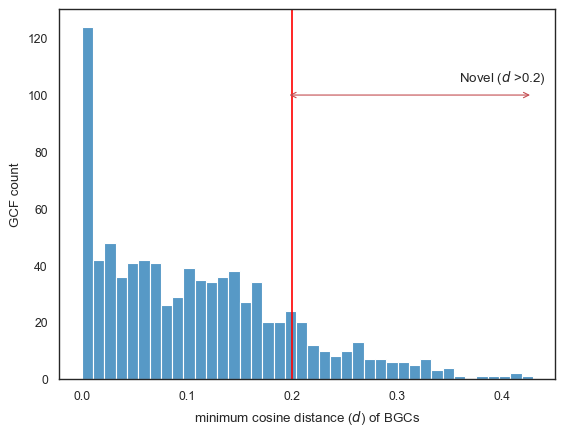

In [35]:
sns.histplot(data=GCF_min,x=GCF_min[0],multiple='stack',bins=40)
plt.axvline(0.2, color='red')
plt.xlabel("Minimum cosine distance ($\it{d}$) of BGCs")
plt.annotate("",
            xy=(0.195, 100), xycoords='data',
            xytext=(max(GCF_min[0]), 100), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
            connectionstyle="arc3", color='r'),
            )

plt.text(0.4, 105, 'Novel ($\it{d}$ >0.2)', horizontalalignment='center')
plt.ylabel("BGC count")
plt.show()

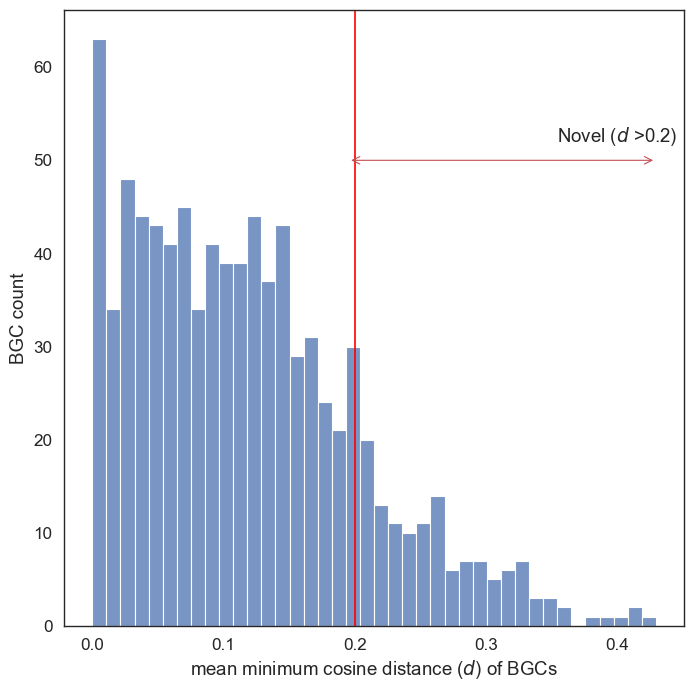

In [153]:

sns.histplot(data=GCF_avg,x=GCF_avg[0],multiple='stack',bins=40)
plt.axvline(0.2, color='red')
plt.xlabel("mean minimum cosine distance ($\it{d}$) of GCFs")
plt.annotate("",
            xy=(0.195, 50), xycoords='data',
            xytext=(max(GCF_avg[0]), 50), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
            connectionstyle="arc3", color='r'),
            )
plt.text(0.4, 52, 'Novel ($\it{d}$ >0.2)', horizontalalignment='center')
plt.ylabel("GCF count")
plt.show()

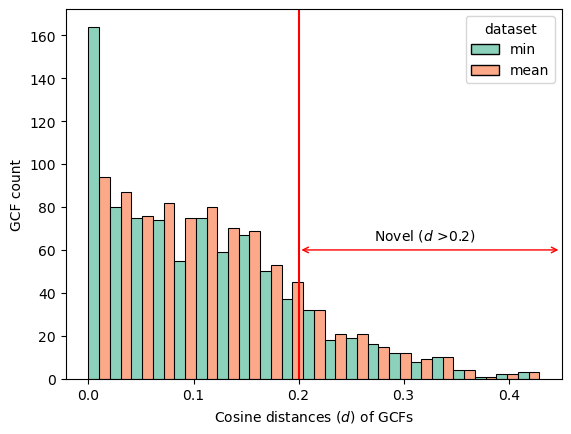

In [7]:
sns.reset_defaults()
GCF_min["dataset"] = "min"
GCF_avg["dataset"] = "mean"
GCF = pd.concat([GCF_min, GCF_avg])
GCF = GCF.reset_index()

sns.histplot(GCF, x=0, hue="dataset", multiple="dodge", palette="Set2", legend=True)
plt.axvline(0.2, color='red')
plt.xlabel("Cosine distances ($\it{d}$) of GCFs")
plt.annotate("", xy=(0.2,60), xycoords='data',
             xytext=(0.45, 60), textcoords='data',
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='r'))
plt.text(0.32, 65, 'Novel ($\it{d}$ >0.2)', horizontalalignment='center')
plt.ylabel("GCF count")
plt.savefig("cosine_dist.svg", format="svg")
plt.show()

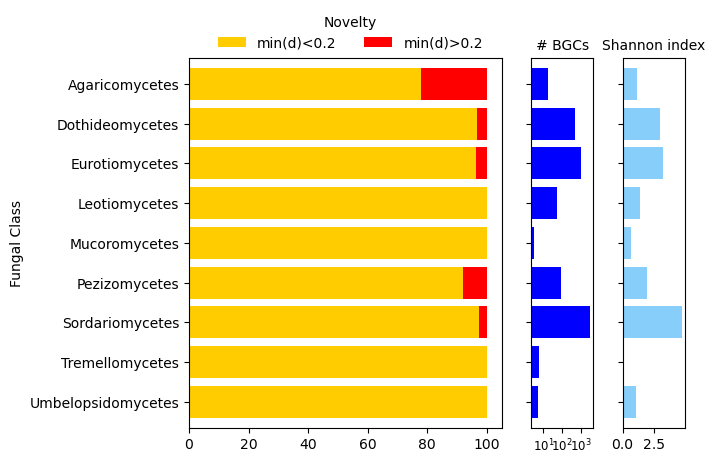

In [8]:
color_dict = {'min(d)<0.2':'#FFCC00','min(d)>0.2':'#ff0000'}

fig, axes = plt.subplots(ncols = 3, sharey = True, gridspec_kw = {'width_ratios': [25, 5,5]})
fungal1[fungal1.columns].div(fungal1[fungal1.columns].sum(axis = 1) * 0.01, axis = 0).plot(kind = 'barh', stacked = True, ax = axes[0], width = 0.8, linewidth = 0, color = color_dict)#, order = class_order)
axes[0].set_ylabel("Fungal Class")
axes[0].legend(ncol = 2, title = 'Novelty', loc = 'best', bbox_to_anchor = (0.48, 0.65, 0.5, 0.5), frameon = False)

fungal1["sum"] = fungal1.sum(axis=1)
fungal1
fungal1[['sum']].plot(ax = axes[1], kind = 'barh', width = 0.8, color = '#0000ff').invert_yaxis()
axes[1].set_xscale('log')
axes[1].tick_params(axis = 'x', labelsize = 8.5)
axes[1].legend().set_visible(False)
axes[1].minorticks_off()
axes[1].set_title('# BGCs', fontsize=10)

diversity[0].plot(kind = 'barh', ax = axes[2], width = 0.8, color = '#87cefa').invert_yaxis()
axes[2].set_title('Shannon index', fontsize = 10)
plt.savefig("fungalbgcs_diversity.svg", format = "svg")
plt.show()

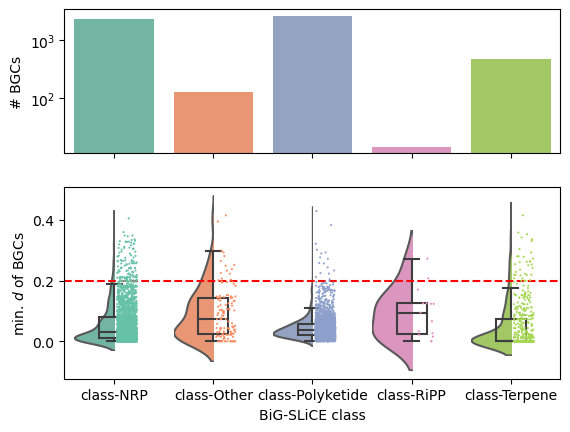

In [9]:
fig, axes = plt.subplots(nrows=2, sharex=True,gridspec_kw={'height_ratios': [1.5, 2]})
graph = sns.barplot(x="BiG-SLiCE class", y='sum', data=fungal2, palette="Set2",ax=axes[0],order=fungal2['BiG-SLiCE class'].to_list())
axes[0].set_yscale('log')
axes[0].set_ylabel('# BGCs')
axes[0].set(xlabel=None)
axes[0].minorticks_off()
# sns.set_style('white')
tips = sns.load_dataset('tips')
palette = sns.cubehelix_palette(start=.5, rot=-.5, dark=0.3, light=0.7)
ax = sns.violinplot(data=minValues1, y='min.cosine', x="BiG-SLiCE class",ax=axes[1],palette="Set2",order=fungal2['BiG-SLiCE class'].to_list(),
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    y0, x0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((y0, x0), width/2, height , transform=ax.transData))

sns.boxplot(data=minValues1, y='min.cosine', x="BiG-SLiCE class", order=fungal2['BiG-SLiCE class'].to_list(),saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=axes[1])
old_len_collections = len(ax.collections)
sns.stripplot(data=minValues1, y='min.cosine', x="BiG-SLiCE class",palette="Set2",order=fungal2['BiG-SLiCE class'].to_list(), ax=axes[1],size=1.5)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.13, 0]))
axes[1].set_ylabel("min. $\it{d}$ of BGCs")
axes[1].axhline(y=0.2, color='r', linestyle='dashed')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig("fungalbgcs_byclass.svg", format="svg")
plt.show()